<a href="https://colab.research.google.com/github/rahafaalsuhaimi-commits/DriverIQ/blob/main/Accident_Prediction_DriverIq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib

In [ ]:
pip install tnkeeh

In [ ]:
pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 6.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=31dabf70e0816c78acf3f4b353775c6a1598402708bf20261ead0f8321902619
  Stored in directory: /root/.cache/pip/wheels/bb/f1/26/f9002669ef6ad80a3c9f1b22880b35d9b4c6650011acee0523
Successfully built emoji


In [ ]:
!pip install transformers

In [ ]:
!pip install Arabic-Stopwords

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 8.1 MB/s eta 0:00:00


In [ ]:
pip install Tashaphyne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
pip install PyArabic

In [ ]:
!pip install emoji

In [ ]:
!pip install openpyxl

In [ ]:
pip install scikit-learn

In [ ]:
import numpy as np
import nltk # Text libarary
# nltk.download('stopwords')
import string
import re
import regex
import emoji
from nltk.corpus import stopwords
import arabicstopwords.arabicstopwords as stp #more range of arabic stop words
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
from tashaphyne.stemming import ArabicLightStemmer

import torch
from transformers import AutoTokenizer, AutoModel
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sentence_transformers import SentenceTransformer
from sklearn.svm import OneClassSVM

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC

In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

# Data

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 260 to 265
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    254 non-null    object
 1   label   254 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


In [ ]:
data.head(50)

# preprocessing

In [ ]:
# Remove numbers and periods
data['Text'] = data['Text'].str.replace(r'[\d.]', '', regex=True)

In [ ]:
data.head()

In [ ]:
data['Text'] = data['Text'].apply(lambda text: Removing_non_arabic(text))
data['Text'] = data['Text'].apply(lambda text: Removing_punctuations(text))
data['Text'] = data['Text'].apply(lambda text: remove_emoji(text))
data = data[data['Text'].str.split().str.len() > 1]

In [ ]:
data.dropna(subset=['Text'], inplace =True)

In [ ]:
data.duplicated().sum()

np.int64(19)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
arabic_stopwords = stopwords.words("arabic")

In [ ]:
def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in arabic_stopwords]
    return " ".join(Text)

def ISRI_Stemmer(text):
    #making an object
    stemmer = ISRIStemmer()

    #stemming each word
    text = stemmer.stem(text)
    text = stemmer.pre32(text)
    text = stemmer.suf32(text)

    return text

def Snowball_stemmer(text):
    text = text.split()
    stemmer = SnowballStemmer("arabic")
    text=[stemmer.stem(y) for y in text]
    return " " .join(text)

def Arabic_Light_Stemmer(text):
    Arabic_Stemmer = ArabicLightStemmer()
    text=[Arabic_Stemmer.light_stem(y) for y in text.split()]

    return " " .join(text)

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)

    #remove repetetions
    text = re.sub("[إأٱآا]", "ا", text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('ييي', 'ي')
    text = text.replace('اا', 'ا')

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)

    # Remove longation
    text = re.sub(r'(.)\1+', r"\1\1", text)

    #Strip vowels from a text, include Shadda.
    text = araby.strip_tashkeel(text)

    #Strip diacritics from a text, include harakats and small lettres The striped marks are
    text = araby.strip_diacritics(text)
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_non_arabic(text):
    text = re.sub('[A-Za-z]+',' ',text)
    return text

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def remove_emoji(string):

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string).strip()


def remove_extra_Space(text):
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    return  " ".join(text.split())


In [ ]:
data.Text=data.Text.apply(lambda text : remove_stop_words(text))

In [ ]:
data.Text=data.Text.apply(lambda text : Removing_non_arabic(text))
#data.Text=data.Text.apply(lambda text : normalizeArabic(text))
data.Text=data.Text.apply(lambda text : Removing_punctuations(text))
#data.Text=data.Text.apply(lambda text : Arabic_Light_Stemmer(text))

TypeError: expected string or bytes-like object, got 'int'

In [ ]:
data.isnull().sum()

,0
Text,0
label,0


In [ ]:
data.to_csv('new_cleand_data.csv', index = False)

# Sentence Transformer

In [ ]:
data = pd.read_excel('balanced_cleand_data.xlsx')
X = data['Text']
y = data['label']

In [ ]:
model = SentenceTransformer("aubmindlab/bert-base-arabertv2") #tokenaization
text_embeddings = model.encode(X.to_list())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Binary SVM


In [ ]:
labels = data["label"].tolist()

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
accs, precs, recs, f1s = [], [], [], []
cm_total = np.zeros((2, 2), dtype=int)

for train_idx, test_idx in cv.split(text_embeddings, labels):
    X_train, X_test = text_embeddings[train_idx], text_embeddings[test_idx]
    y_train, y_test = np.array(labels)[train_idx], np.array(labels)[test_idx]

    svm = SVC(kernel="linear")
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    recs.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

    cm_total += confusion_matrix(y_test, y_pred, labels=[0, 1])

print("Mean Accuracy:", np.mean(accs))
print("Mean Precision:", np.mean(precs))
print("Mean Recall:", np.mean(recs))
print("Mean F1:", np.mean(f1s))

Mean Accuracy: 0.9921568627450981
Mean Precision: 0.9925925925925926
Mean Recall: 0.9923076923076923
Mean F1: 0.9923048464668887


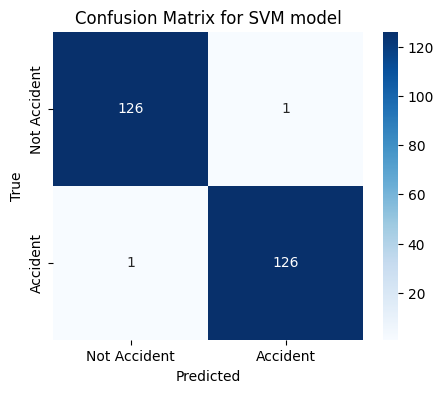

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm_total, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Accident", "Accident"],
            yticklabels=["Not Accident", "Accident"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM model")
plt.show()

for testing using generated data

In [ ]:
gen_data = pd.read_excel('GenData.xlsx')

# Encoding using SentenceTransformer model
gen_text_embeddings = model.encode(gen_data['Text'].to_list())

#predictions
gen_predictions = svm.predict(gen_text_embeddings)

# Ato see the prediction on a Data Frame
gen_data['Predicted_Label'] = gen_predictions

# Compare the predicted and actuall labels
true_labels = gen_data['True_Label']

accuracy = accuracy_score(true_labels, gen_predictions)
precision = precision_score(true_labels, gen_predictions)
recall = recall_score(true_labels, gen_predictions)
f1 = f1_score(true_labels, gen_predictions)

print(f"Accuracy on GenData: {accuracy:.4f}")
print(f"Precision on GenData: {precision:.4f}")
print(f"Recall on GenData: {recall:.4f}")
print(f"F1 Score on GenData: {f1:.4f}")

Accuracy on GenData: 0.9809
Precision on GenData: 0.9836
Recall on GenData: 0.9972
F1 Score on GenData: 0.9903


In [ ]:
gen_data.to_excel('GenData_with_predictions.xlsx', index=False)